# Projeto Filtros AdFG

### Beatriz Evelbauer Simões 

Nesse projeto, visamos comparar diferentes tipos de filtros com relação a diferentes ruídos em uma mesma imagem.

Os filtros propostos são o filtro do kernel da equação do calor e também o de regularização à Tikhonov, este sendo um caso particular de um filtro $ARMA(p,q)$.

Eles são definidos por:

$$\text{heat} (\lambda) = e^{- \tau \lambda}$$

onde $\tau$ é um parâmetro real a ser definido, e

$$\text{Tikhonov} (\lambda) = \frac{1}{1 + \gamma \lambda}$$

onde $\gamma$ é um parâmetro real a ser escolhido. 

Ambos os filtros tem implementação na biblioteca `PyGSP`, com a qual faremos a comparação de desempenho no final do trabalho.

## Imports

In [1]:
pip install opencv-python


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
# bibliotecas 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting 
from PIL import Image, ImageFilter
import scipy.sparse as sp
import cv2 # para mudar o tamanho das fotos

In [2]:
# abrindo imagens
img_original = cv2.imread('cameraman_original.jpg')
img_ruido1 = cv2.imread('cameraman_ruido.jpg')
img_ruido2 = cv2.imread('cameraman_ruido2.jpg')

print("Tamanho original: ", img_original.shape[:2])
print("Tamanho ruido 1: ", img_ruido1.shape[:2])
print("Tamanho ruido 2: ", img_ruido2.shape[:2])

Tamanho original:  (256, 256)
Tamanho ruido 1:  (256, 256)
Tamanho ruido 2:  (256, 256)


### Reduzindo as imagens

In [3]:
img_original = cv2.resize(img_original, (120,120))
img_ruido1 = cv2.resize(img_ruido1, (120,120))
img_ruido2 = cv2.resize(img_ruido2, (120,120))

print("Tamanho original: ", img_original.shape[:2])
print("Tamanho ruido 1: ", img_ruido1.shape[:2])
print("Tamanho ruido 2: ", img_ruido2.shape[:2])

Tamanho original:  (120, 120)
Tamanho ruido 1:  (120, 120)
Tamanho ruido 2:  (120, 120)


In [4]:
# transformando em escala de cinza
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
img_ruido1 = cv2.cvtColor(img_ruido1, cv2.COLOR_BGR2GRAY)
img_ruido2 =  cv2.cvtColor(img_ruido2, cv2.COLOR_BGR2GRAY)

In [6]:
img_original

array([[219, 217, 216, ..., 215, 216, 216],
       [219, 217, 216, ..., 215, 216, 216],
       [219, 217, 216, ..., 215, 216, 216],
       ...,
       [208, 216, 205, ..., 216, 186, 198],
       [225, 224, 220, ..., 186, 190, 189],
       [216, 216, 222, ..., 210, 196, 201]], dtype=uint8)

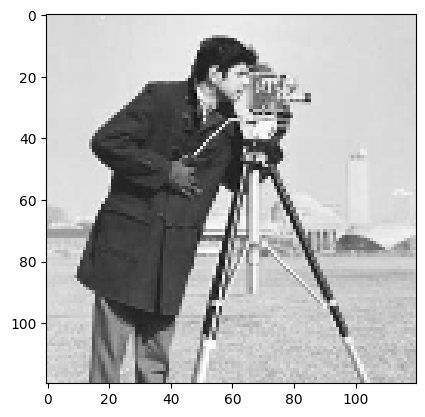

In [11]:
plt.imshow(img_original, cmap='gray')

In [7]:
plt.imsave('cameraman_original_reduzido.png',Image.fromarray(img_original,'L'),cmap='gray')

### Transformando em sinal

In [5]:
sinal_original = np.array(img_original).reshape(120**2)
sinal_ruido1 = np.array(img_ruido1).reshape(120**2)
sinal_ruido2 = np.array(img_ruido2).reshape(120**2)

## Implementação dos filtros e das métricas 

Abaixo, estão definidas as funções utilizadas para calcular os filtros Heat e Tikhonov, bem como as métricas de Erro Quadrático Médio (MSE) e Peak Signal-to-Noise Ratio (PSNR).

Na ordem:

* Heat
* Tikhonov
* MSE
* PSNR

In [6]:
def heat(lam,tau=1):
    '''Calcula a função do filtro a partir de um vetor de autovalores.
    
    Parâmetros:
    - lambda (array) - vetor de autovalores
    
    Return:
    - H (array) - matriz diagonal cujos calores da diagonal são os h(lambda_i) e
    h() é a função que define o filtro
    '''  
    
    h_lambda = np.exp(-(tau * lam)) #h(lam,tau)
    H = np.diag(h_lambda)

    return H


In [7]:
def tikhonov(lam,g=1):
    '''Calcula a matriz H da regularização à tikhonov a partir de
    um vetor de autovalores.
    
    Parâmetros:
    - lam (array): vetor de autovalores
    - g (float): default = 1, valor do parâmetro lambda 
    
    Returns:
    - H (array): matriz diagonal cujas entradas são a função h() 
    calculada sobre os autovalores correspondentes.'''
    
    h_lambda = 1/(1+ g*lam)
    H = np.diag(h_lambda)

    return H

In [8]:
def MSE(original,filtrado):
    '''Calcula o erro quadrático médio da filtração escolhida.
    
    Parâmetros:
    - original (array): sinal original, sem ruídos, para usar como
    referência no MSE
    - filtrado (array): sinal obtido com a filtração
    
    Returns:
    - mse (float): erro quadrático médio'''

    soma = sum((original - filtrado)**2) # soma dos quadrados 
    n = len(filtrado)
    mse = soma/n
    return mse

In [9]:
def PSNR(original,filtrado,img=True):
    '''Calcula o Peak signal-to-noise ratio com relação a alguma fltração
    escolhida. O PSNR é a variação relativa do máximo valor possível
    do sinal em relação ao erro quadrático médio (norma L2 do erro),
    em escala logarítmica.
    
    Parâmetros:
    - original (array): sinal original
    - filtrado (array): sinal filtrado de acordo com a filtração de 
    escolha
    
    Returns: 
    - res (float): medida do PSNR'''
    mse = MSE(original,filtrado) # precisa dessa métrica
    if img:
        max_f = 255
    else: 
        # definindo uma métrica alternativa para meu toy problem
        max_f = max(filtrado)
    res = 20*np.log10(max_f) - 10*np.log10(mse)
    return res

## Grafo Clássico

Nessa seção, vamos fazer todas as contas para os filtros implementados aqui com o grafo construído de maneira clássica, isto é, conectando os pixels adjascentes.

Além disso, vamos dividir os resultados entre os filtros Heat e Tikhonov. 

In [10]:
# primeiro a identificação das bordas
def bordas(img):
    '''Função que recupera os índices de cada uma das bordas de um array (ou imagem).
    
    Parâmetros:
    - img (array): matriz mxn que representa a imagem (ou qualquer outra coisa)
    
    Return:
    - left (list): índices da borda esquerda 
    - right (list): índices da borda direita
    - up (list): índices da borda superior
    - down (list): índices da borda inferior'''
    # matriz m por n 
    m, n = img.shape 

    left = [i*m for i in range(n)]
    right = [i*m - 1 for i in range(1,n+1)]
    up = [i for i in range(m)]
    down = [n*(m-1) + i for i in range(m)]

    return left, right, up, down

In [11]:
def grafo_img_simples(img, adj = False, plot=True):
    '''Função que retorna uma instância do objeto graph do pygsp que
    representa uma imagem. Aqui o grafo é o mais simples possível, considerando
    adjascentes os pixels vizinhos.
       
    Parâmetros:
     - img (array): imagem a partir da qual construiremos o grafo 
     - adj (Bool): default = False, indica se retornamos ou não a matriz de adjascência
      do grafo criado 
     - plot (Bool): default = True, faz o desenho do grafo
    '''
    # primeira coisa é pegar as bordas 
    left, right, up, down = bordas(img)
    m,n = img.shape
    #W = np.zeros((m*n,m*n))
    W = []

    for i in range(m*n):
        linha = np.zeros(m*n,dtype=np.int16)

        if i == 0: # canto superior esquerdo 
            linha[1] = 1 # a direita
            linha[m] = 1 # abaixo
            linha[m+1] = 1 # diagonal p baixo

        elif i == m-1: # canto superior direito
            linha[i-1] = 1 # a esquerda 
            linha[i+m] = 1 # abaixo 
            linha[i+m-1] = 1 # diagonal p baixo

        elif i == n*(m-1): # canto inferior esquerdo 
            linha[i+1] = 1 # a direita
            linha[i-m] = 1 # acima
            linha[i-m+1] = 1

        elif i == n*m -1: # canto inferior direito
            linha[i-1] = 1 # a esquerda
            linha[i-m] = 1 # acima
            linha[i-m-1] = 1

        elif i in up:
           linha[i-1] = 1
           linha[i+1] = 1
           linha[i+m] = 1
           linha[i+m-1] = 1
           linha[i+m+1] = 1
            
        elif i in left:
            linha[i+1] = 1
            linha[i-m] = 1
            linha[i+m] = 1
            linha[i-m+1] = 1
            linha[i+m+1] = 1
        
        elif i in right:
            linha[i-m] = 1
            linha[i+m] = 1
            linha[i-1] = 1
            linha[i-m-1] =1
            linha[i+m-1] = 1

        elif i in down:
            linha[i-1] - 1
            linha[i+1] = 1
            linha[i-m] = 1
            linha[i-m+1] = 1
            linha[i-m-1] = 1

        else:
            linha[i-m-1] = 1
            linha[i-m] = 1
            linha[i-m+1] = 1
            linha[i-1] = 1
            linha[i+1] = 1
            linha[i+m-1] = 1
            linha[i+m] = 1
            linha[i+m+1] = 1
        
        W.append(linha)
    W = sp.csc_matrix(np.array(W, dtype=np.int16))
    #assert W.shape == (m*n,m*n)
    
    # criando o grafo 
    G = graphs.Graph(W)
    
    if adj:
        return G, W
    elif plot:
        G.set_coordinates()
        G.plot(title=f"Grafo trivial para imagem {m}x{n}")
        return G
    else:
        return G

Note que essa construção independe do sinal, então vamos fazê-la a partir da imagem original e computar somente os filtros a partir das imagens com ruido.

In [12]:
G_classico = grafo_img_simples(img_original, False, False)

### Heat

In [13]:
# calculando autofunções
G_classico.compute_fourier_basis()

2024-06-04 17:29:46,825:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (14400 x 14400) may take some time.


In [14]:
U = G_classico.U # autofunções
lam = G_classico.e # autovalores

In [15]:
aux1 = U.T @ sinal_ruido1
aux2 = U.T @ sinal_ruido2

In [16]:
# calculando a filtração 
tau = [1/4, 1/2, 1, 2, 4]

heat_ruido1 = [] # resultados da filtração 
heat_ruido2 = []

# listas para guardar as métricas de erro
mse_heat1, mse_heat2 = [], []
psnr_heat1, psnr_heat2 = [], []
for t in tau:
    # calculando o sinal filtrado
    r1 = U @ heat(lam, tau = t) @ aux1
    r2 = U @ heat(lam, tau = t) @ aux2

    # guardando resultados
    heat_ruido1.append(np.round(r1))
    heat_ruido2.append(np.round(r2))

    # metricas de erro
    mse_heat1.append(MSE(sinal_original,r1))
    mse_heat2.append(MSE(sinal_original,r2))
    psnr_heat1.append(PSNR(sinal_original,r1))
    psnr_heat2.append(PSNR(sinal_original,r2))

In [17]:
heat_ruido1[0]

array([218., 217., 215., ..., 201., 195., 199.])

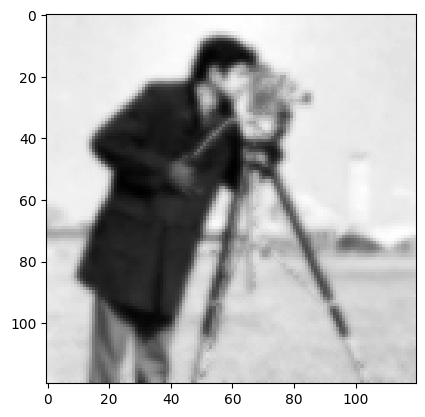

In [20]:
plt.imshow(heat_ruido1[0].reshape((120,120)), cmap='gray')

In [18]:
sinal_original

array([219, 217, 216, ..., 210, 196, 201], dtype=uint8)

### Tikhonov

In [21]:
tik_ruido1 = np.round(U @ tikhonov(lam, 1) @ aux1)
tik_ruido2 = np.round(U @ tikhonov(lam) @ aux2)

mse_tik1 = MSE(sinal_original, tik_ruido1) 
mse_tik2 = MSE(sinal_original, tik_ruido2)
psnr_tik1 = PSNR(sinal_original, tik_ruido1)
psnr_tik2 = PSNR(sinal_original, tik_ruido2)

### Resultados 

Primeiro vamos comparar os resultados numéricos e depois a olho nu.

In [22]:
labels = [f'Heat (t = {ts})' for ts in tau] + ["Tikhonov"]
mse1 = mse_heat1 + [mse_tik1]
psnr1 = psnr_heat1 + [psnr_tik1]
mse2 = mse_heat2 + [mse_tik2]
psnr2 = psnr_heat2 + [psnr_tik2]
resultados = pd.DataFrame(data = np.array([labels,
                                            mse1,
                                            mse2,
                                            psnr1,
                                            psnr2]).T,
                            columns = ['Método','MSE 1', 'MSE 2', 'PSNR 1','PSNR 2'])
resultados

,Método,MSE 1,MSE 2,PSNR 1,PSNR 2
0,Heat (t = 0.25),385.6933539509512,418.70953644868547,22.268382054535046,21.911675084555995
1,Heat (t = 0.5),574.6065954549341,593.8760083265701,20.537097542602854,20.3938458006276
2,Heat (t = 1),778.9973438827305,788.7803466441925,19.215443839900058,19.161242797389022
3,Heat (t = 2),1011.65337692934,1016.3161799487822,18.08048625313855,18.060515211826285
4,Heat (t = 4),1263.7198316111026,1266.2998516182977,17.114295599216433,17.10543804883327
5,Tikhonov,569.3659722222222,587.9668055555555,20.576888526016038,20.437275527696396


In [23]:
cameraman_classico_ruido1_heat1 = Image.fromarray(heat_ruido1[0].reshape((120,120)), 'L')
cameraman_classico_ruido1_heat2 = Image.fromarray(heat_ruido1[1].reshape((120,120)), 'L')
cameraman_classico_ruido1_heat3 = Image.fromarray(heat_ruido1[2].reshape((120,120)), 'L') 
cameraman_classico_ruido1_heat4 = Image.fromarray(heat_ruido1[3].reshape((120,120)), 'L') 
cameraman_classico_ruido1_heat5 = Image.fromarray(heat_ruido1[4].reshape((120,120)), 'L') 

cameraman_classico_ruido2_heat1 = Image.fromarray(heat_ruido2[0].reshape((120,120)), 'L')
cameraman_classico_ruido2_heat2 = Image.fromarray(heat_ruido2[1].reshape((120,120)), 'L')
cameraman_classico_ruido2_heat3 = Image.fromarray(heat_ruido2[2].reshape((120,120)), 'L') 
cameraman_classico_ruido2_heat4 = Image.fromarray(heat_ruido2[3].reshape((120,120)), 'L') 
cameraman_classico_ruido2_heat5 = Image.fromarray(heat_ruido2[4].reshape((120,120)), 'L') 

cameraman_classico_ruido1_tik = Image.fromarray(tik_ruido1.reshape((120,120)),'L')
cameraman_classico_ruido2_tik = Image.fromarray(tik_ruido2.reshape((120,120)),'L')


In [30]:
# salvando as imagens 
# ruido 1
plt.imsave('cameraman_CR1H1.png', heat_ruido1[0].reshape((120,120)), cmap='gray')
plt.imsave('cameraman_CR1H2.png', heat_ruido1[1].reshape((120,120)), cmap='gray')
plt.imsave('cameraman_CR1H3.png', heat_ruido1[2].reshape((120,120)), cmap='gray')
plt.imsave('cameraman_CR1H4.png', heat_ruido1[3].reshape((120,120)), cmap='gray')
plt.imsave('cameraman_CR1H5.png', heat_ruido1[4].reshape((120,120)), cmap='gray')

# tikhonov
plt.imsave('cameraman_CR1TIK.png', tik_ruido1.reshape((120,120)), cmap='gray')

# ruido 2
plt.imsave('cameraman_CR2H1.png', heat_ruido2[0].reshape((120,120)), cmap='gray')
plt.imsave('cameraman_CR2H2.png', heat_ruido2[1].reshape((120,120)), cmap='gray')
plt.imsave('cameraman_CR2H3.png', heat_ruido2[2].reshape((120,120)), cmap='gray')
plt.imsave('cameraman_CR2H4.png', heat_ruido2[3].reshape((120,120)), cmap='gray')
plt.imsave('cameraman_CR2H5.png', heat_ruido2[4].reshape((120,120)), cmap='gray')

# tikhonov
plt.imsave('cameraman_CR2TIK.png', tik_ruido2.reshape((120,120)), cmap='gray')

#### Ruido 1
Original|Heat 1|Heat 2|Heat 3|Heat 4|Heat 5|Tikhonov
:---:|:---:|:---:|:---:|:---:|:---:|:---:
![cameraman_original_reduzido.png](cameraman_original_reduzido.png)| ![cameraman_CR1H1.png](cameraman_CR1H1.png)| ![cameraman_CR1H2.png](cameraman_CR1H2.png)| ![cameraman_CR1H3.png](cameraman_CR1H3.png)| ![cameraman_CR1H4.png](cameraman_CR1H4.png)| ![cameraman_CR1H5.png](cameraman_CR1H5.png)| ![cameraman_CR1TIK.png](cameraman_CR1TIK.png)

#### Ruido 2
Original|Heat 1|Heat 2|Heat 3|Heat 4|Heat 5|Tikhonov
:---:|:---:|:---:|:---:|:---:|:---:|:---:
![cameraman_original_reduzido.png](cameraman_original_reduzido.png)| ![cameraman_CR2H1.png](cameraman_CR2H1.png)| ![cameraman_CR2H2.png](cameraman_CR2H2.png)| ![cameraman_CR2H3.png](cameraman_CR2H3.png)| ![cameraman_CR2H4.png](cameraman_CR2H4.png)| ![cameraman_CR2H5.png](cameraman_CR2H5.png)| ![cameraman_CR2TIK.png](cameraman_CR2TIK.png)

## Grafo com Pesos

Nessa seção, introduzimos um novo método para construção dos grafos, em que é aplicado um peso Gaussiano quando dois vértices são $\kappa$-próximos, ou seja, 

$$a_{ij} = e^{- d^2 / 2 \sigma^2}, \text{se} |d(i,j)| < \kappa$$

A distância aqui utilizada é a diferença entre as cores de cada pixel em grayscale.

In [31]:
def grafo_peso_grayscale(img,th,kap,adj=False,plot=True):
    '''Função que constrói o grafo para uma imagem em escala de cinzas
    a partir do gradiente de cor. Os pesos atribuidos a cada vértice serão
    uma gaussiana de variância theta^2 avaliada em em x = gray(i) - gray(j), 
     onde gray() é o valor na escala de cinzas de cada pixel.
      
    Parâmetros:
     - img (array): matrix representando a imagem, suas entradas correspondem ao valor
     de cada vértice na escala de cinza
     - th (float): desvio padrão da Gaussiana
     - kap (float): threshold de conexão dos vértices'''
    
    m,n = img.shape
    img_array = np.array(img).reshape(n*m)
    N = m*n
    W = np.zeros((N,N))
    #W = sp.coo_matrix(shape=(N,N),dtype=np.float16)
    for i in range(N):
        for j in range(N):
            dist = abs(img_array[i] - img_array[j])
            #print(img[ij,ii],img[jj,ji],dist)
            if dist < kap and i!=j:
                W[i,j] = np.exp(-((dist*dist)/(2*th*th)), dtype=np.float32)
                #print(W[i,j])
                assert W[i,j] <= 1 
    
    G = graphs.Graph(W)
    if adj:
        return G, W
    elif plot:
        G.set_coordinates()
        G.plot(title=f"Grafo com pesos $\kappa =$ {kap}")
        return G
    else:
        return G
    

Diferentemente do primeiro grafo, essa construção depende do valor do sinal para calcular as distâncias entre os vértices, então temos um grafo para cada ruído diferente.

In [32]:
G_ruido1_peso = grafo_peso_grayscale(img_ruido1, 1, 5, False,False)
G_ruido2_peso = grafo_peso_grayscale(img_ruido2, 1, 5, False,False)

C:\Users\Beatriz\AppData\Local\Temp\ipykernel_8364\622753297.py:20: RuntimeWarning: overflow encountered in scalar subtract
  dist = abs(img_array[i] - img_array[j])


In [33]:
G_ruido1_peso.compute_fourier_basis()
G_ruido1_peso.e[0] = 0 

2024-06-04 19:42:38,647:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (14400 x 14400) may take some time.


In [34]:
G_ruido2_peso.compute_fourier_basis()
G_ruido2_peso.e[0] = 0

2024-06-04 19:55:28,647:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (14400 x 14400) may take some time.


In [35]:
U_peso1 = G_ruido1_peso.U
lam1 = G_ruido1_peso.e 

U_peso2 = G_ruido2_peso.U
lam2 = G_ruido2_peso.e

aux1 = U_peso1.T @ sinal_ruido1
aux2 = U_peso2.T @ sinal_ruido2

### Heat

In [36]:
# calculando a filtração 
tau = [1/4, 1/2, 1, 2, 4]

heat_peso1 = [] # resultados da filtração 
heat_peso2 = []

# listas para guardar as métricas de erro
mse_peso1, mse_peso2 = [], []
psnr_peso1, psnr_peso2 = [], []
for t in tau:
    # calculando o sinal filtrado
    r1 = U_peso1 @ heat(lam1, tau = t) @ aux1
    r2 = U_peso2 @ heat(lam2, tau = t) @ aux2

    # guardando resultados
    heat_peso1.append(np.round(r1))
    heat_peso2.append(np.round(r2))

    # metricas de erro
    mse_peso1.append(MSE(sinal_original,r1))
    mse_peso2.append(MSE(sinal_original,r2))
    psnr_peso1.append(PSNR(sinal_original,r1))
    psnr_peso2.append(PSNR(sinal_original,r2))

### Tikhonov

In [37]:
tik_peso1 = np.round(U_peso1 @ tikhonov(lam1, 1) @ aux1)
tik_peso2 = np.round(U_peso2 @ tikhonov(lam2) @ aux2)

mse_tik_peso1 = MSE(sinal_original, tik_peso1) 
mse_tik_peso2 = MSE(sinal_original, tik_peso2)
psnr_tik_peso1 = PSNR(sinal_original, tik_peso1)
psnr_tik_peso2 = PSNR(sinal_original, tik_peso2)

### Resultados

Como no caso anterior, vamos fazer os resultados numéricos primeiro.

In [39]:
labels = [f'Heat (t = {ts})' for ts in tau] + ["Tikhonov"]
resultados = pd.DataFrame(data = np.array([labels,
                                            mse_peso1 + [mse_tik_peso1],
                                            mse_peso2 + [mse_tik_peso2],
                                            psnr_peso1 + [psnr_tik_peso1],
                                            psnr_peso2 + [psnr_tik_peso2]]).T,
                            columns = ['Método','MSE 1','MSE 2','PSNR 1','PSNR 2'])
resultados

,Método,MSE 1,MSE 2,PSNR 1,PSNR 2
0,Heat (t = 0.25),103.62961104472936,193.0923929203873,27.975964927573106,25.27315196243228
1,Heat (t = 0.5),108.28641218137489,193.14107556954627,27.785063962543305,25.272057152803853
2,Heat (t = 1),118.67292071659539,198.4331257023082,27.38728729739951,25.154661874607594
3,Heat (t = 2),137.93444014433112,212.8867042816674,26.734076443860808,24.849318221980944
4,Heat (t = 4),165.46265733469053,236.73832675835607,25.943803660395815,24.388117871288944
5,Tikhonov,111.77090277777778,194.32590277777777,27.64751602109687,25.245496668884478


Agora, a comparação a olho nu.

In [34]:
cameraman_peso_ruido1_heat1 = Image.fromarray(heat_peso1[0].reshape((120,120)), 'L')
cameraman_peso_ruido1_heat2 = Image.fromarray(heat_peso1[1].reshape((120,120)), 'L')
cameraman_peso_ruido1_heat3 = Image.fromarray(heat_peso1[2].reshape((120,120)), 'L') 
cameraman_peso_ruido1_heat4 = Image.fromarray(heat_peso1[3].reshape((120,120)), 'L') 
cameraman_peso_ruido1_heat5 = Image.fromarray(heat_peso1[4].reshape((120,120)), 'L') 

cameraman_peso_ruido2_heat1 = Image.fromarray(heat_peso2[0].reshape((120,120)), 'L')
cameraman_peso_ruido2_heat2 = Image.fromarray(heat_peso2[1].reshape((120,120)), 'L')
cameraman_peso_ruido2_heat3 = Image.fromarray(heat_peso2[2].reshape((120,120)), 'L') 
cameraman_peso_ruido2_heat4 = Image.fromarray(heat_peso2[3].reshape((120,120)), 'L') 
cameraman_peso_ruido2_heat5 = Image.fromarray(heat_peso2[4].reshape((120,120)), 'L') 

cameraman_peso_ruido1_tik = Image.fromarray(tik_peso1.reshape((120,120)),'L')
cameraman_peso_ruido2_tik = Image.fromarray(tik_peso2.reshape((120,120)),'L')


In [41]:
# salvando as imagens 
# ruido 1
plt.imsave('cameraman_PR1H1.png', heat_peso1[0].reshape((120,120)), cmap='gray')
plt.imsave('cameraman_PR1H2.png', heat_peso1[1].reshape((120,120)), cmap='gray')
plt.imsave('cameraman_PR1H3.png', heat_peso1[2].reshape((120,120)), cmap='gray')
plt.imsave('cameraman_PR1H4.png', heat_peso1[3].reshape((120,120)), cmap='gray')
plt.imsave('cameraman_PR1H5.png', heat_peso1[4].reshape((120,120)), cmap='gray')

# tikhonov
plt.imsave('cameraman_PR1TIK.png', tik_peso1.reshape((120,120)), cmap='gray')

# ruido 2
plt.imsave('cameraman_PR2H1.png', heat_peso2[0].reshape((120,120)), cmap='gray')
plt.imsave('cameraman_PR2H2.png', heat_peso2[1].reshape((120,120)), cmap='gray')
plt.imsave('cameraman_PR2H3.png', heat_peso2[2].reshape((120,120)), cmap='gray')
plt.imsave('cameraman_PR2H4.png', heat_peso2[3].reshape((120,120)), cmap='gray')
plt.imsave('cameraman_PR2H5.png', heat_peso2[4].reshape((120,120)), cmap='gray')

# tikhonov
plt.imsave('cameraman_PR2TIK.png', tik_peso2.reshape((120,120)), cmap='gray')

#### Ruido 1 - Pesos
Original|Heat 1|Heat 2|Heat 3|Heat 4|Heat 5|Tikhonov
:---:|:---:|:---:|:---:|:---:|:---:|:---:
![cameraman_original_reduzido.png](cameraman_original_reduzido.png)| ![cameraman_PR1H1.png](cameraman_PR1H1.png)| ![cameraman_PR1H2.png](cameraman_PR1H2.png)| ![cameraman_PR1H3.png](cameraman_PR1H3.png)| ![cameraman_PR1H4.png](cameraman_PR1H4.png)| ![cameraman_PR1H5.png](cameraman_PR1H5.png)| ![cameraman_PR1TIK.png](cameraman_PR1TIK.png)

#### Ruido 2 - Pesos
Original|Heat 1|Heat 2|Heat 3|Heat 4|Heat 5|Tikhonov
:---:|:---:|:---:|:---:|:---:|:---:|:---:
![cameraman_original.png](cameraman_original_reduzido.png)| ![cameraman_PR2H1.png](cameraman_PR2H1.png)| ![cameraman_PR2H2.png](cameraman_PR2H2.png)| ![cameraman_PR2H3.png](cameraman_PR2H3.png)| ![cameraman_PR2H4.png](cameraman_PR2H4.png)| ![cameraman_PR2H5.png](cameraman_PR2H5.png)| ![cameraman_PR2TIK.png](cameraman_PR2TIK.png)

## Comparação com o PyGSP

Como o filtro de regularização à Tikhonov não é implementado em nenhum método do PyGSP, vamos comparar apenas com o filtro heat.

Como o `compute_fourier_basis` é comum aos dois métodos, basta calcular $Uh(\lambda)U^T x$, onde:

* $U$ é a matriz de autovetores de $L$
* $h(\lambda)$ é a função que define o filtro aplicada aos autovalores
* $x$ é o sinal

### Ruido 1

In [46]:
%%timeit
U @ heat(lam, tau = 1) @ U.T @ sinal_ruido1

1min 16s ± 1.68 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
%%timeit
U_peso1 @ heat(lam1, tau = 1) @ U_peso1.T @ sinal_ruido1

5min 45s ± 890 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
%%timeit
filters.Heat(G_classico,1).filter(sinal_ruido1,method='exact')

873 ms ± 65.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Ruido 2

In [49]:
%%timeit
U @ heat(lam, tau = 1) @ U.T @ sinal_ruido2

1min 14s ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%%timeit 
U_peso2 @ heat(lam2, tau = 1)  @ U_peso2.T @ sinal_ruido2

1min 14s ± 195 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit
filters.Heat(G_classico,1).filter(sinal_ruido2,method='exact')

827 ms ± 26.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Resultados

Vemos, claramente, que o método de filtro do PyGSP é mais otimizado e 